In [3]:
!pip install matplotlib


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


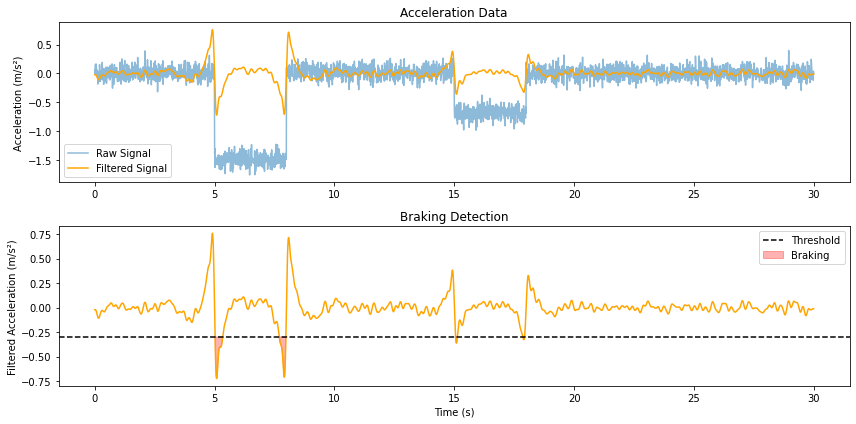

Detected 4 braking events:
Event 1: 5.0s to 5.3s
Event 2: 7.7s to 8.0s
Event 3: 15.1s to 15.1s
Event 4: 17.9s to 17.9s


In [9]:

# --- Generate Synthetic Data ---
np.random.seed(42)
fs = 100  # Sampling frequency (Hz)
t = np.arange(0, 30, 1/fs)  # 30 seconds of data

# Create gravity vector (static acceleration)
gravity = np.array([0.005, 0.21, 9.77])  # Assume slight tilt in sensor

# Create dynamic acceleration (deceleration events)
decel_events = np.zeros_like(t)
decel_events[500:800] = -1.5  # Hard brake at 5-8 seconds
decel_events[1500:1800] = -0.7  # Moderate brake at 15-18 seconds

# Combine components (assuming x-axis is forward)
x_accel = gravity[0] + decel_events + 0.1*np.random.randn(len(t))  # Add noise

# --- Preprocessing ---
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Remove gravity (high-pass filter)
b, a = butter_highpass(0.5, fs)  # 0.5Hz cutoff
x_filtered = filtfilt(b, a, x_accel)

# Smooth signal (low-pass filter)
b, a = butter_lowpass(5, fs)  # 5Hz cutoff
x_filtered = filtfilt(b, a, x_filtered)

# --- Brake Detection ---
threshold = -0.3  # m/s² (adjust based on vehicle)
braking = x_filtered < threshold

# Find start/end times of braking events
changes = np.diff(braking.astype(int))
start_times = t[1:][changes == 1]
end_times = t[1:][changes == -1]

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Raw vs Filtered Signal
plt.subplot(2, 1, 1)
plt.plot(t, x_accel, label='Raw Signal', alpha=0.5)
plt.plot(t, x_filtered, label='Filtered Signal', color='orange')
plt.title("Acceleration Data")
plt.ylabel("Acceleration (m/s²)")
plt.legend()

# Braking Events
plt.subplot(2, 1, 2)
plt.plot(t, x_filtered, color='orange')
plt.fill_between(t, x_filtered, threshold, where=(x_filtered < threshold), 
                 color='red', alpha=0.3, label='Braking')
plt.axhline(threshold, color='black', linestyle='--', label='Threshold')
plt.title("Braking Detection")
plt.xlabel("Time (s)")
plt.ylabel("Filtered Acceleration (m/s²)")
plt.legend()

plt.tight_layout()
plt.show()

# --- Print Results ---
print(f"Detected {len(start_times)} braking events:")
for i, (start, end) in enumerate(zip(start_times, end_times)):
    print(f"Event {i+1}: {start:.1f}s to {end:.1f}s")

Detected 4 braking events:

Event 1: 5.0s to 5.3s
Pre-event samples: 100
Post-event samples: 100
X-axis pre-event mean: 0.17 m/s²
X-axis post-event mean: -1.29 m/s²

Event 2: 7.7s to 8.0s
Pre-event samples: 100
Post-event samples: 100
X-axis pre-event mean: -1.30 m/s²
X-axis post-event mean: 0.19 m/s²

Event 3: 15.1s to 15.1s
Pre-event samples: 100
Post-event samples: 100
X-axis pre-event mean: 0.18 m/s²
X-axis post-event mean: -0.51 m/s²

Event 4: 17.9s to 17.9s
Pre-event samples: 100
Post-event samples: 100
X-axis pre-event mean: -0.49 m/s²
X-axis post-event mean: 0.15 m/s²


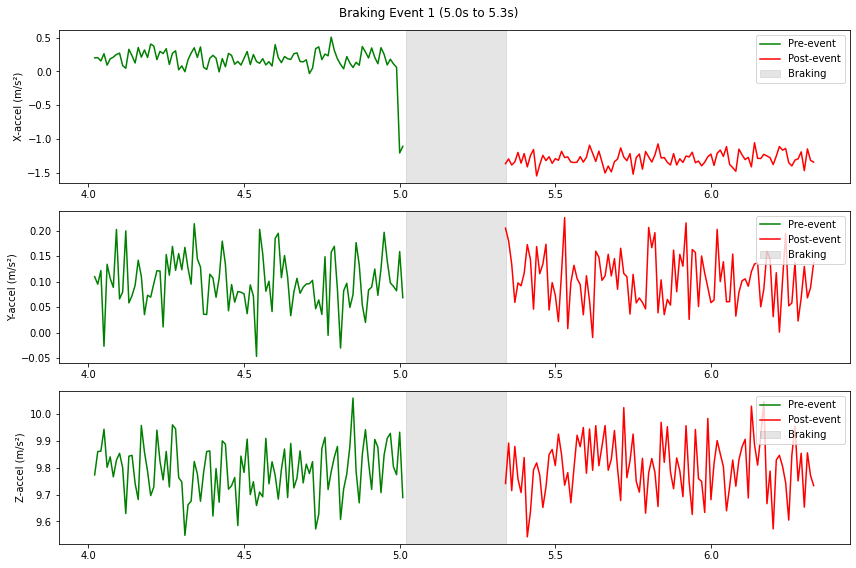

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from collections import defaultdict

# --- Generate Synthetic 3-Axis Data ---
np.random.seed(42)
fs = 100  # Sampling frequency (Hz)
t = np.arange(0, 30, 1/fs)  # 30 seconds of data

# Gravity vector (static acceleration)
gravity = np.array([0.2, 0.1, 9.81])  # Slight tilt in x/y axes

# Create dynamic acceleration (deceleration events)
decel_events = np.zeros_like(t)
decel_events[500:800] = -1.5  # Hard brake at 5-8 seconds
decel_events[1500:1800] = -0.7  # Moderate brake at 15-18 seconds

# Generate 3-axis data with noise
x_accel = gravity[0] + decel_events + 0.1*np.random.randn(len(t))
y_accel = gravity[1] + 0.05*np.random.randn(len(t))  # Small lateral variations
z_accel = gravity[2] + 0.1*np.random.randn(len(t))   # Vertical vibrations

# --- Preprocessing (x-axis only) ---
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Process x-axis for brake detection
b, a = butter_highpass(0.5, fs)
x_filtered = filtfilt(b, a, x_accel)
b, a = butter_lowpass(5, fs)
x_filtered = filtfilt(b, a, x_filtered)

# --- Brake Detection & Data Recording ---
threshold = -0.3
braking = x_filtered < threshold
changes = np.diff(braking.astype(int))
event_starts = t[1:][changes == 1]
event_ends = t[1:][changes == -1]

# Configure recording windows
pre_window = 1.0  # Seconds before event to record
post_window = 1.0  # Seconds after event to record

events_data = []

for start, end in zip(event_starts, event_ends):
    # Convert times to indices
    start_idx = np.searchsorted(t, start)
    end_idx = np.searchsorted(t, end)
    
    # Get pre-event data
    pre_start_idx = max(0, start_idx - int(pre_window * fs))
    pre_data = {
        'x': x_accel[pre_start_idx:start_idx],
        'y': y_accel[pre_start_idx:start_idx],
        'z': z_accel[pre_start_idx:start_idx],
        'times': t[pre_start_idx:start_idx]
    }
    
    # Get event+post data
    post_end_idx = min(len(t), end_idx + int(post_window * fs))
    post_data = {
        'x': x_accel[end_idx:post_end_idx],
        'y': y_accel[end_idx:post_end_idx],
        'z': z_accel[end_idx:post_end_idx],
        'times': t[end_idx:post_end_idx]
    }
    
    events_data.append({
        'start': start,
        'end': end,
        'pre_event': pre_data,
        'post_event': post_data
    })

# --- Visualization ---
def plot_event_data(event_num):
    event = events_data[event_num]
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    axes = ['x', 'y', 'z']
    
    for i, axis in enumerate(axes):
        # Pre-event data
        axs[i].plot(event['pre_event']['times'], 
                   event['pre_event'][axis],
                   'g', label='Pre-event')
        
        # Post-event data
        axs[i].plot(event['post_event']['times'], 
                   event['post_event'][axis],
                   'r', label='Post-event')
        
        # Event duration
        axs[i].axvspan(event['start'], event['end'], 
                      alpha=0.2, color='gray', label='Braking')
        
        axs[i].set_ylabel(f"{axis.upper()}-accel (m/s²)")
        axs[i].legend(loc='upper right')
    
    plt.suptitle(f"Braking Event {event_num+1} ({event['start']:.1f}s to {event['end']:.1f}s)")
    plt.tight_layout()
    plt.show()

# --- Print Summary ---
print(f"Detected {len(events_data)} braking events:")
for i, event in enumerate(events_data):
    print(f"\nEvent {i+1}: {event['start']:.1f}s to {event['end']:.1f}s")
    print(f"Pre-event samples: {len(event['pre_event']['x'])}")
    print(f"Post-event samples: {len(event['post_event']['x'])}")
    print(f"X-axis pre-event mean: {np.mean(event['pre_event']['x']):.2f} m/s²")
    print(f"X-axis post-event mean: {np.mean(event['post_event']['x']):.2f} m/s²")

# Plot first event details
plot_event_data(0)